## Imports/Installs

In [1]:
! pip install wrds

In [2]:
import wrds
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import minimize

from sklearn.covariance import LedoitWolf
import cvxpy as cp

import matplotlib.pyplot as plt

## Data Acquisition and Coverage Validation

Data Acquisition and Coverage Validation
- Connect to the WRDS database to retrieve monthly return data for a user-defined set of stock
tickers.
- Implement a ticker data coverage validation routine that ensures stocks have sufficient consecutive return observations in an estimation window, allowing for limited missing months.
- Design a user-interaction loop to replace insufficient tickers with alternatives until all tickers
pass the coverage test.

In [3]:
db = wrds.Connection()


Loading library list...
Done


In [20]:
def get_monthly_returns(tickers, start_date, end_date):
    query = f"""
        SELECT permno, date, ret
        FROM crsp.msf
        WHERE permno IN ({','.join(map(str, tickers))})
            AND date BETWEEN '{start_date}' AND '{end_date}'
        ORDER BY permno, date
    """
    df = db.raw_sql(query)
    return df

def coverage_check(df, tickers, min_observations, max_missing):
    failed = []
    coverage = {}
    for ticker in tickers:
        returns = df[df['permno'] == ticker].sort_values('date')
        obs_count = len(returns)
        missing_count = returns['ret'].isna().sum()
        # Sample requirement: must have min_observations, with at most max_missing gaps
        if obs_count < min_observations or missing_count > max_missing:
            failed.append(ticker)
        coverage[ticker] = (obs_count, missing_count)
    return failed, coverage

def user_interaction_loop(db, initial_tickers, start_date, end_date, min_observations, max_missing):
    tickers = initial_tickers.copy()
    while True:
        df = get_monthly_returns(tickers, start_date, end_date)
        failed, coverage = coverage_check(df, tickers, min_observations, max_missing)
        print("Coverage summary:", coverage)
        if not failed:
            print("All tickers passed coverage validation.")
            return df
        print(f"Tickers failing coverage: {failed}")
        for f in failed:
            replacement = input(f"Replace ticker {f} with a new ticker (permno): ")
            idx = tickers.index(f)
            tickers[idx] = int(replacement)

# Example usage
initial_tickers = [12490, 10107, 12060]  # replace with actual permno values
start_date = "2015-01-01"
end_date = "2025-06-30"
min_observations = 120  # e.g. 10 years monthly
max_missing = 2

final_data = user_interaction_loop(db, initial_tickers, start_date, end_date, min_observations, max_missing)
returns = final_data.pivot(index='date', columns='permno', values='ret')



Coverage summary: {12490: (120, np.int64(0)), 10107: (120, np.int64(0)), 12060: (120, np.int64(0))}
All tickers passed coverage validation.


In [5]:
final_data

,permno,date,ret
0,10107,2015-01-30,-0.130248
1,10107,2015-02-27,0.093069
2,10107,2015-03-31,-0.072862
3,10107,2015-04-30,0.196409
4,10107,2015-05-29,-0.030222
...,...,...,...
355,12490,2024-08-30,0.060685
356,12490,2024-09-30,0.093752
357,12490,2024-10-31,-0.064954
358,12490,2024-11-29,0.108166


## Portfolio Weight Constraints

- Prompt the user to specify maximum long and short position constraints for assets in the
portfolio.
- Design the optimization problem so these constraints can optionally be applied

In [21]:
def optimize_portfolio(mu, cov, max_long=1.0, max_short=0.0):
    n_assets = len(mu)
    # Objective: minimize portfolio variance
    def portfolio_variance(w):
        return w.T @ cov @ w

    # Constraint: weights sum to 1 (fully invested)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    # Bounds: apply long and short constraints to each asset
    bounds = [(max_short, max_long) for _ in range(n_assets)]
    # Start with equal weights
    initial_weights = np.array([1/n_assets] * n_assets)

    result = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=[constraints])
    return result.x

def optimize_port_user_input():
    max_long = float(input("Maximum long position per asset (e.g., 0.7 for 70%): "))
    max_short = float(input("Maximum short position per asset (e.g., -0.3 for -30%): "))
    return max_long, max_short

# Test
mu = np.array([0.07, 0.08, 0.10])
cov = np.array([[0.02, 0.01, 0.01],
                [0.01, 0.03, 0.01],
                [0.01, 0.01, 0.04]])

# Prompt user for constraints

max_long, max_short = optimize_port_user_input()

test_weights = optimize_portfolio(mu, cov, max_long, max_short)
print("Optimal weights:", test_weights)


Maximum long position per asset (e.g., 0.7 for 70%): 0.7
Maximum short position per asset (e.g., -0.3 for -30%): -0.3
Optimal weights: [0.54579773 0.27275118 0.18145109]


## Minimum Variance Portfolio Optimization

- Calculate the sample covariance matrix from the estimation period return data.
- Implement Ledoit-Wolf covariance shrinkage estimator using the sklearn package.
- Solve the minimum variance portfolio by minimizing portfolio variance subject to:
    - Weights summing to 1 (fully invested)
    - User-specified long/short position limits
- Use cvxpy to perform the constrained quadratic programming optimization efficiently

In [22]:
def min_var_portfolio(returns, max_long=1.0, max_short=0.0):
    # Step 1: Sample covariance matrix
    sample_cov = returns.cov().values

    # Step 2: Ledoit-Wolf covariance shrinkage estimator
    lw_model = LedoitWolf()
    lw_model.fit(returns.values)
    shrink_cov = lw_model.covariance_

    n_assets = returns.shape[1]
    w = cp.Variable(n_assets)

    # Objective: minimize portfolio variance
    objective = cp.quad_form(w, shrink_cov)

    # Constraints: weights sum to 1, bounds for long/short limits
    constraints = [cp.sum(w) == 1]
    constraints += [w >= max_short, w <= max_long]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()

    return w.value

# Example usage
np.random.seed(88)
weights = min_var_portfolio(returns, max_long, max_short)
print("Minimum Variance Portfolio Weights:", weights)

Minimum Variance Portfolio Weights: [0.47170458 0.13361749 0.39467794]


## Rolling Window Out-of-Sample Backtesting

- Implement a rolling window scheme to:
    - Re-estimate covariance matrices monthly with a fixed-length look-back window.
    - Solve for portfolio weights using both sample and Ledoit-Wolf covariance estimates.
    - Compute out-of-sample portfolio returns for the month following each estimation
window

In [25]:
def min_var_portfolio(returns_window, max_long=1.0, max_short=0.0, shrinkage=True):
    if shrinkage:
        lw = LedoitWolf().fit(returns_window.values)
        cov = lw.covariance_
    else:
        cov = returns_window.cov().values

    n_assets = returns_window.shape[1]
    w = cp.Variable(n_assets)
    objective = cp.quad_form(w, cov)
    constraints = [cp.sum(w) == 1, w >= max_short, w <= max_long]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()
    return w.value

def rolling_backtest(returns, window=36, max_long=1.0, max_short=0.0):
    dates = returns.index
    out_returns = []
    out_dates = []

    for i in range(len(dates) - window - 1):
        train = returns.iloc[i:i+window]
        test = returns.iloc[i+window+1]

        weights_shrink = min_var_portfolio(train, max_long=max_long, max_short=max_short, shrinkage=True)
        weights_sample = min_var_portfolio(train, max_long=max_long, max_short=max_short, shrinkage=False)

        ret_shrink = np.dot(test.values, weights_shrink)
        ret_sample = np.dot(test.values, weights_sample)

        out_returns.append({'ledoit_wolf': ret_shrink, 'sample': ret_sample})
        out_dates.append(dates[i+window+1])

    return pd.DataFrame(out_returns, index=out_dates)


# Apply rolling backtest with 6-month look-back window
weights = rolling_backtest(returns, 36, max_long, max_short)
weights


,ledoit_wolf,sample
2018-02-28,-0.058626,-0.062115
2018-03-29,-0.028690,-0.027315
2018-04-30,0.003380,-0.007493
2018-05-31,0.015237,0.005838
2018-06-29,-0.012859,-0.013261
...,...,...
2024-08-30,0.031387,0.033008
2024-09-30,0.068445,0.067548
2024-10-31,-0.066262,-0.063378
2024-11-29,0.074401,0.076322


## Performance Metrics and Diagnostics

- track and report portfolio performance metrics across the backtest period:
    - Out-of-sample cumulative returns, annualized return, volatility, Sharpe ratio.
    - Portfolio turnover based on weight changes month-to-month.
    - Stability of portfolio weights as measured by cross-sectional standard deviation.
- Create and interpret visualization plots including:
    - Cumulative return curves.
    - Turnover distributions and time series.

In [28]:
def performance_metrics(portfolio_returns, periods_per_year=12):
    """
    Calculate cumulative returns, annualized return, volatility, and Sharpe ratio.
    portfolio_returns: pd.Series of periodic portfolio returns
    """
    cumulative_return = (1 + portfolio_returns).prod() - 1
    annualized_return = (1 + cumulative_return) ** (periods_per_year / len(portfolio_returns)) - 1
    annualized_vol = portfolio_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else np.nan

    return {
        'cumulative_return': cumulative_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio
    }

def portfolio_turnover(weights_series):
    """
    Calculate turnover as sum of absolute month-to-month weight changes.
    weights_series: pd.DataFrame where each row is portfolio weights at a time point
    """
    turnover = weights_series.diff().abs().sum(axis=1).fillna(0)
    return turnover

def weight_stability(weights_series):
    """
    Calculate cross-sectional std deviation of portfolio weights over time.
    """
    return weights_series.std(axis=1)

def display_performance_metrics(estimate):
    print(f"{estimate} Performance Metrics:")
    a = performance_metrics(weights[estimate])
    for key in a:
        print(f"{key:21} : {a[key]}")

# Calculate metrics
display_performance_metrics("ledoit_wolf")
print()
display_performance_metrics("sample")



ledoit_wolf Performance Metrics:
cumulative_return     : 2.240457687938641
annualized_return     : 0.18528450107384842
annualized_volatility : 0.20288350652740797
sharpe_ratio          : 0.9132556127662252

sample Performance Metrics:
cumulative_return     : 2.412941980697802
annualized_return     : 0.19420497993197183
annualized_volatility : 0.1960779984507414
sharpe_ratio          : 0.9904475844634854


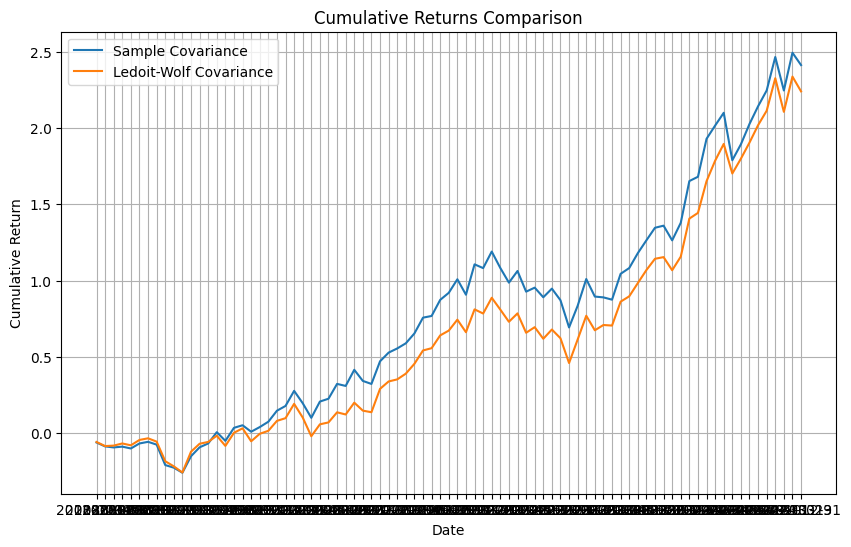

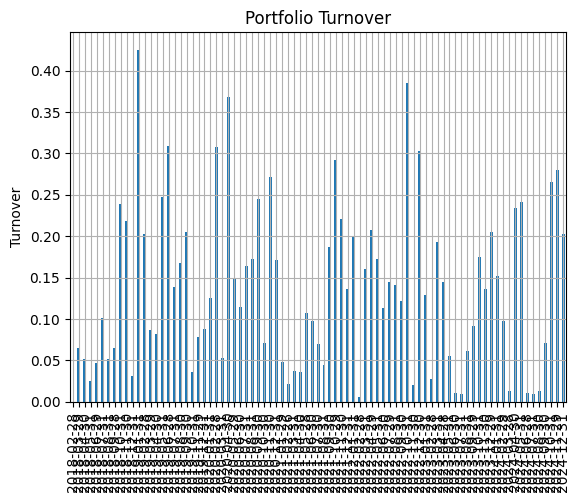

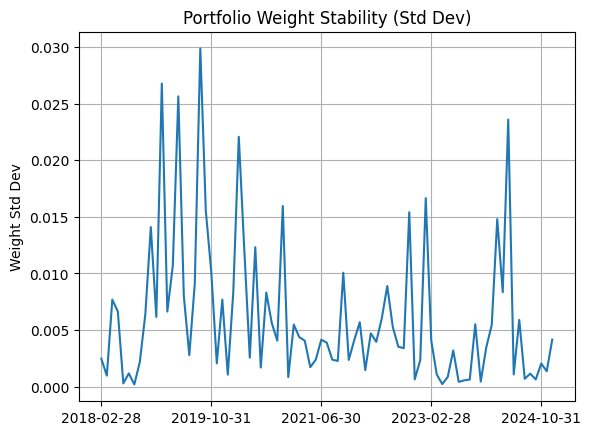

In [27]:
def plot_cumulative_returns(sample_returns, ledoit_wolf_returns):
    """
    Plot cumulative returns for sample and Ledoit-Wolf portfolios.

    sample_returns, ledoit_wolf_returns: pd.Series of returns indexed by date
    """
    cumulative_sample = (1 + sample_returns).cumprod() - 1
    cumulative_lw = (1 + ledoit_wolf_returns).cumprod() - 1

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_sample, label='Sample Covariance')
    plt.plot(cumulative_lw, label='Ledoit-Wolf Covariance')
    plt.title("Cumulative Returns Comparison")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_turnover(turnover_series):
    turnover_series.plot(kind='bar', title="Portfolio Turnover")
    plt.ylabel("Turnover")
    plt.grid(True)
    plt.show()

def plot_weight_stability(stability_series):
    stability_series.plot(title="Portfolio Weight Stability (Std Dev)")
    plt.ylabel("Weight Std Dev")
    plt.grid(True)
    plt.show()

# Calculate turnover and stability
turnover = portfolio_turnover(weights)
stability = weight_stability(weights)

# Visualizations
plot_cumulative_returns(weights['sample'], weights['ledoit_wolf'])
plot_turnover(turnover)
plot_weight_stability(stability)